# Librerías

In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from radiomics import featureextractor, imageoperations
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones

In [21]:
def resample_to_reference(moving_image, reference_image, is_mask=False):
    """
    Remuestrea una imagen hacia el espacio de otra imagen de referencia.
    
    Args:
        moving_image (sitk.Image): Imagen a remuestrear
        reference_image (sitk.Image): Imagen de referencia
        is_mask (bool): Si es True, usa interpolación de vecino más cercano para preservar valores de etiquetas
                        Si es False, usa interpolación lineal para imágenes de intensidad
    
    Returns:
        sitk.Image: Imagen remuestreada al espacio de referencia
    """

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference_image)
    if is_mask:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkLinear)
    return resample.Execute(moving_image)

def bias_field_correction(image_float32, 
                          shrink_factor=4, 
                          control_points=[4, 4, 4]):
    """
    Aplica corrección de campo de sesgo N4 a una imagen. Para normalizar intensidades en imágenes médicas.
    
    Args:
        image_float32 (sitk.Image): Imagen en formato float32
        shrink_factor (int): Factor de reducción para acelerar el procesamiento 
        control_points (list): Puntos de control para el algoritmo N4
    
    Returns:
        sitk.Image: Imagen con corrección de campo de sesgo
    """
    # Reducir la imagen para acelerar el procesamiento
    shrinked_image = sitk.Shrink(image_float32, [shrink_factor] * image_float32.GetDimension())
    
    # Configurar y aplicar el filtro N4
    bias_field_filter = sitk.N4BiasFieldCorrectionImageFilter()
    bias_field_filter.SetNumberOfControlPoints(control_points)
    bias_field_filter.UseMaskLabelOff()
    
    bias_field_filter.Execute(shrinked_image)
    
    # Aplicar la corrección a la imagen original
    log_bias_field = bias_field_filter.GetLogBiasFieldAsImage(image_float32)
    bias_corrected_image = image_float32 / sitk.Exp(log_bias_field)
    
    return bias_corrected_image

def preprocess_image(image):
    """
    Aplica preprocesamiento a una imagen: conversión a float32, corrección de campo de sesgo y reducción de ruido  con difusión anisotrópica..
    
    Args:
        image (sitk.Image): Imagen original
    
    Returns:
        sitk.Image: Imagen preprocesada
    """
    # Conversión a float32 para operaciones numéricas
    image_float32 = sitk.Cast(image, sitk.sitkFloat32)

    # Corrección de campo de sesgo para normalizar intensidades
    bias_corrected_image = bias_field_correction(image_float32)

    # Reducción de ruido mediante difusión anisotrópica
    denoised_image = sitk.CurvatureAnisotropicDiffusion(bias_corrected_image, timeStep=0.01875)

    return denoised_image

def extract_radiomic_features(extractor_local, image_sitk, mask, patient_id, study_id, label_value, mask_type="gland"):
    """
    Extrae características radiómicas de una imagen utilizando PyRadiomics.
    
    Args:
        extractor_local (RadiomicsFeatureExtractor): Objeto extractor configurado
        image_sitk (sitk.Image): Imagen preprocesada
        mask (sitk.Image o str): Máscara o ruta a la máscara
        patient_id (str): ID del paciente
        study_id (str): ID del estudio
        label_value (int): Valor de la etiqueta (0 o 1 para case_csPCa)
        mask_type (str): Tipo de máscara: "gland" para glándula prostática o "full" para imagen completa
    
    Returns:
        dict: Diccionario con características radiómicas y metadatos
    """
    # Si la máscara es una ruta, cárgala
    if isinstance(mask, str):
        mask_sitk = sitk.ReadImage(mask)
    else:
        mask_sitk = mask

    # Asegura que la máscara tenga la misma geometría que la imagen
    mask_sitk = resample_to_reference(mask_sitk, image_sitk, is_mask=True)


    # Ejecutar extracción de características
    features = extractor_local.execute(image_sitk, mask_sitk)
    
    # Añadir metadatos al diccionario de salida
    out_dict = {
        "patient_id": patient_id,
        "study_id": study_id,
        "label": label_value,
        "mask_type": mask_type
    }
    for k, v in features.items():
        out_dict[k] = v
        
    return out_dict

def process_row(row):
    patient_id = row["ID"]
    image_path = row["Image"]
    mask_path = row["Mask"]
    # Puedes añadir más campos si los necesitas

    if os.path.isfile(image_path) and os.path.isfile(mask_path):
        try:
            mask_image = sitk.ReadImage(mask_path)
            image = sitk.ReadImage(image_path)
            preprocessed = preprocess_image(image)
            extractor_local = featureextractor.RadiomicsFeatureExtractor("/mnt/datalake/openmind/MedP-Midas/src/radiomics/Params.yaml")
            features = extract_radiomic_features(
                extractor_local,
                image_sitk=preprocessed,
                mask=mask_image,
                patient_id=patient_id,
                study_id="",      # Si no tienes este campo, puedes dejarlo vacío o eliminarlo de la función
                label_value=""    # Igual, si no tienes etiqueta, puedes dejarlo vacío o eliminarlo
            )
            return features
        except Exception as e:
            logger.error(f"Error procesando paciente {patient_id}: {e}", exc_info=True)
            return None
    else:
        logger.warning(f"Imagen o máscara no encontrada para paciente {patient_id}")
        return None

def main():
    """
    Función principal que coordina la extracción de características radiómicas en paralelo.
    Lee los datos de entrada, procesa cada fila en paralelo y guarda los resultados en CSV.
    """
    

# Código

In [4]:
# Definición de rutas de entrada
input_csv = '/mnt/datalake/openmind/MedP-Midas/data/filtered_midas900_t2w.csv' # CSV con información de pacientes e imágenes

## Definición de rutas para archivos CSV de salida
output_csv_label = '/mnt/datalake/openmind/MedP-Midas/data/features_t2w_gland_label1.csv'  # Características T2W

# Carpeta para logs (puedes cambiarla si lo prefieres)
log_dir = '/mnt/datalake/openmind/MedP-Midas/data'
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, "radiomics_processing.log")

## Configuración de logging
logger = logging.getLogger("RadiomicsProcessing")
logger.setLevel(logging.INFO)
logger.propagate = False
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

# Configuración de salida a consola
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# Salida a archivo
file_handler = logging.FileHandler(log_path, mode='w')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
logger.info("Iniciando procesamiento de características radiómicas")

df = pd.read_csv(input_csv)
features_list = []

max_workers = min(4, multiprocessing.cpu_count())
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(process_row, row): idx for idx, row in df.iterrows()}
    with tqdm(total=len(futures), desc="Procesando imágenes") as pbar:
        for future in as_completed(futures):
            row_result = future.result()
            if row_result is not None:
                features_list.append(row_result)
            pbar.update(1)

pd.DataFrame(features_list).to_csv(output_csv_label, index=False)
logger.info("Extracción completada. Archivo CSV generado.")



2025-05-28 15:48:54,712 - INFO - Iniciando procesamiento de características radiómicas
2025-05-28 15:48:54,712 - INFO - Iniciando procesamiento de características radiómicas
Procesando imágenes:   0%|          | 0/717 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmet

# Unir CSV


In [11]:
from functools import reduce

csv_files = [
    ('/mnt/datalake/openmind/MedP-Midas/data/features_t2w/features_t2w_gland_label1.csv', 'label1'),
    ('/mnt/datalake/openmind/MedP-Midas/data/features_t2w/features_t2w_gland_label2.csv', 'label2'),
    ('/mnt/datalake/openmind/MedP-Midas/data/features_t2w/features_t2w_gland_label3.csv', 'label3'),
    ('/mnt/datalake/openmind/MedP-Midas/data/features_t2w/features_t2w_gland_label4.csv', 'label4'),
    ('/mnt/datalake/openmind/MedP-Midas/data/features_t2w/features_t2w_gland_label5.csv', 'label5')
]


dfs = []
for file, label in csv_files:
    df = pd.read_csv(file)
    # Renombra todas las columnas excepto patient_id
    df = df.rename(columns={col: f"{col}_{label}" for col in df.columns if col != 'patient_id'})
    dfs.append(df)

# Une todos los dataframes por patient_id
df_merged = reduce(lambda left, right: pd.merge(left, right, on='patient_id', how='outer'), dfs)

df_merged.to_csv('/mnt/datalake/openmind/MedP-Midas/data/merged_labels.csv', index=False)

In [18]:
# Rutas de tus archivos
archivo_principal = '/mnt/datalake/openmind/MedP-Midas/data/features_t2w/features_t2w_gland_label5.csv'
archivo_pfirrmann = '/mnt/datalake/openmind/MedP-Midas/data/filtered_midas900_t2w_partition.csv'

# Cargar los archivos
df_main = pd.read_csv(archivo_principal)
df_pfirrmann = pd.read_csv(archivo_pfirrmann)

# Seleccionar solo las columnas necesarias
df_pfirrmann = df_pfirrmann[['ID', '1', '2', '3', '4', '5']]

# Unir usando patient_id <-> ID
df_final = df_main.merge(df_pfirrmann, left_on='patient_id', right_on='ID', how='left')

# Eliminar la columna ID duplicada si no la quieres
df_final = df_final.drop(columns=['ID'])

# Guardar el resultado
df_final.to_csv('/mnt/datalake/openmind/MedP-Midas/data/features_t2w_gland_label5_with_pfirrmann.csv', index=False)
df_final.head()

,patient_id,study_id,label,mask_type,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,...,exponential_gldm_LargeDependenceLowGrayLevelEmphasis,exponential_gldm_LowGrayLevelEmphasis,exponential_gldm_SmallDependenceEmphasis,exponential_gldm_SmallDependenceHighGrayLevelEmphasis,exponential_gldm_SmallDependenceLowGrayLevelEmphasis,1,2,3,4,5
0,s_10095,NaN,NaN,gland,v3.0.1,1.26.4,3.0.0.dev30,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,61.357453,1.0,0.022682,0.022682,0.022682,4.0,4.0,3.0,2.0,2.0
1,s_10223,NaN,NaN,gland,v3.0.1,1.26.4,3.0.0.dev30,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,59.283208,1.0,0.026293,0.026293,0.026293,4.0,3.0,2.0,2.0,2.0
2,s_10087,NaN,NaN,gland,v3.0.1,1.26.4,3.0.0.dev30,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,62.219396,1.0,0.023635,0.023635,0.023635,4.0,3.0,3.0,3.0,3.0
3,s_10168,NaN,NaN,gland,v3.0.1,1.26.4,3.0.0.dev30,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,60.839330,1.0,0.025470,0.025470,0.025470,5.0,5.0,4.0,4.0,4.0
4,s_10067,NaN,NaN,gland,v3.0.1,1.26.4,3.0.0.dev30,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,62.115039,1.0,0.024378,0.024378,0.024378,3.0,3.0,3.0,3.0,3.0


# Análisis Pfirrmann


In [5]:
# Carga el archivo combinado
df = pd.read_csv('/mnt/datalake/openmind/MedP-Midas/data/merged_labels_with_pfirrmann.csv')

# Análisis 1: Conteo de valores únicos para cada disco (1-5)
for col in ['1', '2', '3', '4', '5']:
    print(f"Conteo de grados Pfirrmann para el disco {col}:")
    print(df[col].value_counts(dropna=False))
    print()

# Análisis 2: Estadísticas descriptivas generales
print("Estadísticas descriptivas de los grados Pfirrmann:")
print(df[['1', '2', '3', '4', '5']].describe())

# Análisis 3: Conteo total de cada grado (sumando todos los discos)
all_grades = pd.concat([df['1'], df['2'], df['3'], df['4'], df['5']])
print("Conteo total de cada grado Pfirrmann en todos los discos:")
print(all_grades.value_counts(dropna=False))

# Análisis 4: ¿Cuántos pacientes tienen al menos un disco con grado 5?
pacientes_con_grado5 = df[(df[['1', '2', '3', '4', '5']] == 5).any(axis=1)]
print(f"Número de pacientes con al menos un disco grado 5: {len(pacientes_con_grado5)}")

Conteo de grados Pfirrmann para el disco 1:
1
4.0    380
3.0    193
5.0     93
2.0     38
1.0     13
Name: count, dtype: int64

Conteo de grados Pfirrmann para el disco 2:
2
4.0    416
3.0    190
2.0     51
5.0     46
1.0     14
Name: count, dtype: int64

Conteo de grados Pfirrmann para el disco 3:
3
3.0    300
4.0    284
2.0     91
5.0     23
1.0     19
Name: count, dtype: int64

Conteo de grados Pfirrmann para el disco 4:
4
3.0    329
4.0    206
2.0    141
5.0     25
1.0     16
Name: count, dtype: int64

Conteo de grados Pfirrmann para el disco 5:
5
3.0    336
2.0    188
4.0    161
5.0     26
1.0      6
Name: count, dtype: int64

Estadísticas descriptivas de los grados Pfirrmann:
                1           2           3          4           5
count  717.000000  717.000000  717.000000  717.00000  717.000000
mean     3.700139    3.598326    3.280335    3.11576    3.018131
std      0.827706    0.793055    0.824429    0.83682    0.816010
min      1.000000    1.000000    1.000000    1.00

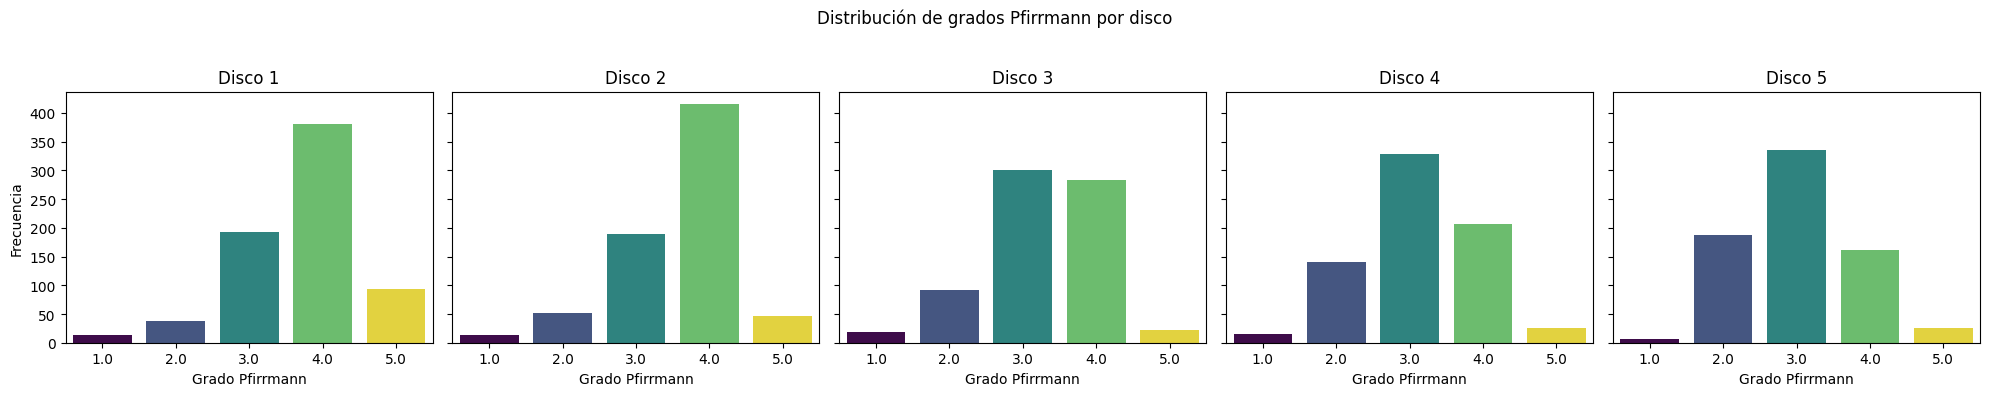

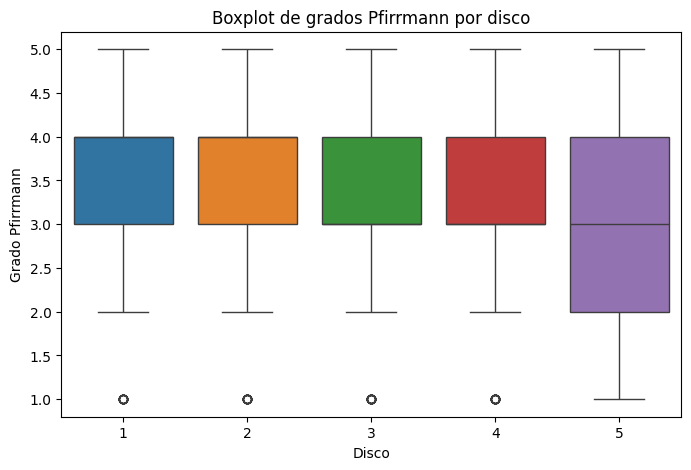

/tmp/ipykernel_1087838/3791516640.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=all_grades, palette="magma")


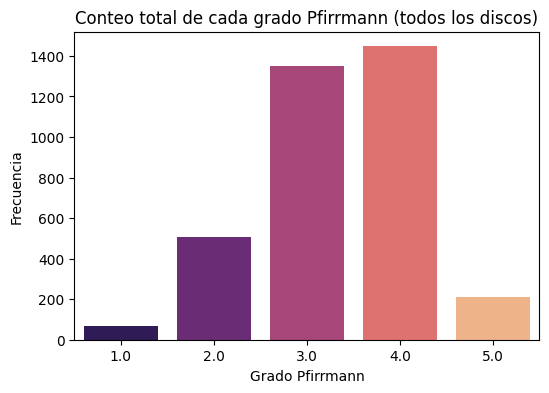

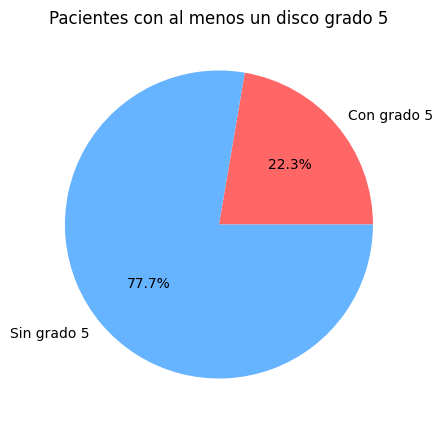

In [ ]:

# Carga el archivo combinado
df = pd.read_csv('/mnt/datalake/openmind/MedP-Midas/data/merged_labels_with_pfirrmann.csv')

# --- Gráfico 1: Barras para cada disco ---
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
for i, col in enumerate(['1', '2', '3', '4', '5']):
    sns.countplot(x=df[col], ax=axs[i], palette="viridis", hue=df[col], legend=False)
    axs[i].set_title(f'Disco {col}')
    axs[i].set_xlabel('Grado Pfirrmann')
    axs[i].set_ylabel('Frecuencia' if i == 0 else '')
plt.suptitle('Distribución de grados Pfirrmann por disco')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Gráfico 2: Boxplot de los grados por disco ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['1', '2', '3', '4', '5']])
plt.title('Boxplot de grados Pfirrmann por disco')
plt.xlabel('Disco')
plt.ylabel('Grado Pfirrmann')
plt.show()

# --- Gráfico 3: Barras del total de grados (todos los discos juntos) ---
all_grades = pd.concat([df['1'], df['2'], df['3'], df['4'], df['5']])
plt.figure(figsize=(6, 4))
sns.countplot(x=all_grades, palette="magma")
plt.title('Conteo total de cada grado Pfirrmann (todos los discos)')
plt.xlabel('Grado Pfirrmann')
plt.ylabel('Frecuencia')
plt.show()

# --- Gráfico 4: Pacientes con al menos un disco grado 5 ---
pacientes_con_grado5 = df[(df[['1', '2', '3', '4', '5']] == 5).any(axis=1)]
labels = ['Con grado 5', 'Sin grado 5']
sizes = [len(pacientes_con_grado5), len(df) - len(pacientes_con_grado5)]
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff6666', '#66b3ff'])
plt.title('Pacientes con al menos un disco grado 5')
plt.show()

# Features radiomics


## Liberías Radiomics Features Model Development


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, balanced_accuracy_score, make_scorer, matthews_corrcoef

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.multitest import multipletests
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
from sklearn.model_selection import StratifiedGroupKFold


import seaborn as sns
from sklearn.metrics import roc_curve
from scipy.stats import kruskal, f_oneway

from statsmodels.stats.multitest import multipletests



Modelo para disco 1 

In [5]:
label_csv= "label5"
num_label = label_csv[-1]
features_outcome_df = pd.read_csv(f'/mnt/datalake/openmind/MedP-Midas/data/features_t2w/features_t2w_{label_csv}_with_pfirrmann.csv')
y = features_outcome_df[f"{num_label}"]
groups = features_outcome_df["patient_id"]
X = features_outcome_df.drop([ 'patient_id','1', '2', '3', '4', '5','study_id', 'label', 'mask_type',
                              'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 
                              'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 
                              'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 
                              'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 
                              'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 
                              'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 
                              'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 
                              'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 
                              'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 
                              'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 
                              'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 
                              'diagnostics_Image-interpolated_Spacing', 'diagnostics_Image-interpolated_Size', 
                              'diagnostics_Image-interpolated_Mean', 'diagnostics_Image-interpolated_Minimum', 
                              'diagnostics_Image-interpolated_Maximum', 'diagnostics_Mask-interpolated_Spacing', 
                              'diagnostics_Mask-interpolated_Size', 'diagnostics_Mask-interpolated_BoundingBox', 
                              'diagnostics_Mask-interpolated_VoxelNum', 'diagnostics_Mask-interpolated_VolumeNum', 
                              'diagnostics_Mask-interpolated_CenterOfMassIndex', 'diagnostics_Mask-interpolated_CenterOfMass', 
                              'diagnostics_Mask-interpolated_Mean', 'diagnostics_Mask-interpolated_Minimum', 
                              'diagnostics_Mask-interpolated_Maximum',], axis=1)

In [6]:
# define random state variable for reproducibility

random_state_value = 1
print_information = False

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=random_state_value)
sgkf.split(X, y, groups)
train_index, test_index = next(sgkf.split(X, y, groups))
if print_information:
    print(f"  Train: index={train_index}")
    print(f"         size={len(train_index)}")
    print(f"         group={groups[train_index]}")
    print(f"  Test:  index={test_index}")
    print(f"         size={len(test_index)}")
    print(f"         group={groups[test_index]}")

X_train = X.iloc[train_index]
Y_train = y.iloc[train_index]

X_test = X.iloc[test_index]
Y_test = y.iloc[test_index]

# Transform Clinically Significant labels from True/False to 1/0 using LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.transform(Y_test)

display(X_train)
display(Y_train)
display(y_train)

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,exponential_gldm_GrayLevelNonUniformity,exponential_gldm_GrayLevelVariance,exponential_gldm_HighGrayLevelEmphasis,exponential_gldm_LargeDependenceEmphasis,exponential_gldm_LargeDependenceHighGrayLevelEmphasis,exponential_gldm_LargeDependenceLowGrayLevelEmphasis,exponential_gldm_LowGrayLevelEmphasis,exponential_gldm_SmallDependenceEmphasis,exponential_gldm_SmallDependenceHighGrayLevelEmphasis,exponential_gldm_SmallDependenceLowGrayLevelEmphasis
0,0.646294,0.199087,10.061180,50.536542,52.569967,50.285034,34.938437,53.038118,10952.953314,32.661478,...,5763.0,0.0,1.0,61.357453,61.357453,61.357453,1.0,0.022682,0.022682,0.022682
1,0.751181,0.226451,11.728712,51.793662,54.293262,49.573488,39.744946,55.309797,14884.002121,38.906424,...,7182.0,0.0,1.0,59.283208,59.283208,59.283208,1.0,0.026293,0.026293,0.026293
2,0.840122,0.242377,13.064490,53.901450,60.820120,55.907478,47.944112,60.845875,19916.769614,45.283797,...,10456.0,0.0,1.0,62.219396,62.219396,62.219396,1.0,0.023635,0.023635,0.023635
3,0.706573,0.191102,13.170591,68.919244,73.123103,70.911282,53.161263,73.656820,26633.165472,48.696445,...,13257.0,0.0,1.0,60.839330,60.839330,60.839330,1.0,0.025470,0.025470,0.025470
4,0.702898,0.206763,12.305845,59.516624,61.074137,56.251837,42.241998,61.878359,19035.732805,41.834109,...,10014.0,0.0,1.0,62.115039,62.115039,62.115039,1.0,0.024378,0.024378,0.024378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0.665596,0.227993,13.621107,59.743560,60.976500,56.826918,42.043717,61.320979,20261.379203,39.765104,...,9759.0,0.0,1.0,60.575981,60.575981,60.575981,1.0,0.026050,0.026050,0.026050
711,0.781744,0.234469,9.787163,41.741787,44.487611,41.385930,33.405005,45.390217,9017.425950,32.631400,...,5217.0,0.0,1.0,61.129960,61.129960,61.129960,1.0,0.022719,0.022719,0.022719
712,0.735130,0.183987,11.265039,61.227517,63.532881,60.053588,47.241811,63.620504,19750.454683,45.010186,...,9751.0,0.0,1.0,61.399959,61.399959,61.399959,1.0,0.023912,0.023912,0.023912
713,0.777507,0.233126,10.650019,45.683514,50.007342,43.181272,36.588592,50.229646,11366.368328,35.519269,...,5485.0,0.0,1.0,59.187420,59.187420,59.187420,1.0,0.025101,0.025101,0.025101


0      2.0
1      2.0
2      3.0
3      4.0
4      3.0
      ... 
710    4.0
711    2.0
712    4.0
713    3.0
714    3.0
Name: 5, Length: 536, dtype: float64

array([1, 1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 1, 1, 2, 3, 1, 2, 3, 4, 2, 2,
       3, 2, 3, 1, 4, 3, 2, 1, 1, 3, 2, 4, 3, 1, 1, 2, 3, 2, 2, 2, 2, 2,
       1, 3, 3, 2, 2, 4, 1, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 1, 1, 1,
       1, 1, 4, 2, 4, 2, 2, 1, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 2, 2, 3, 1, 2, 2, 2, 2, 3,
       2, 2, 3, 1, 2, 2, 2, 2, 4, 2, 2, 2, 3, 4, 2, 2, 2, 1, 2, 3, 0, 2,
       1, 3, 2, 1, 2, 3, 1, 3, 3, 1, 3, 4, 1, 1, 1, 1, 3, 2, 3, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 4, 2, 2,
       2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 4, 1, 3, 1, 1, 3,
       2, 2, 1, 1, 1, 1, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1, 2, 1, 2, 2, 2, 3,
       1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 4, 2, 4, 2, 1, 2, 3,
       2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 3, 2, 2,
       2, 1, 2, 3, 1, 2, 1, 1, 3, 2, 2, 3, 1, 2, 2, 3, 1, 4, 3, 2, 3, 2,
       2, 3, 2, 3, 1, 3, 3, 1, 2, 1, 2, 1, 0, 1, 3,

In [7]:
feature_names, test_type_list, pvalue_list = ([] for _ in range(3))
for column in X_train:
    stat, p = shapiro(X_train[column])
    grupos = [X_train[column][y_train == clase] for clase in np.unique(y_train)]
    feature_names.append(column)
    alpha = 0.05
    if p > alpha:
        test_type_list.append('ANOVA')
        stats, pval = f_oneway(*grupos)
    else:
        test_type_list.append('Kruskal-Wallis')
        stats, pval = kruskal(*grupos)
    pvalue_list.append(pval)

train_auc_pvals_df = pd.DataFrame(list(zip(test_type_list, pvalue_list)),
                                  index=feature_names,
                                  columns=['Test', 'p-value'])

train_auc_pvals_df.sort_values(by='p-value', ascending=True)

,Test,p-value
original_glcm_Imc2,Kruskal-Wallis,6.616295e-53
log-sigma-0-6-mm-3D_firstorder_10Percentile,Kruskal-Wallis,1.141897e-52
squareroot_glcm_Imc2,Kruskal-Wallis,1.789503e-52
original_glcm_ClusterTendency,Kruskal-Wallis,2.818416e-52
exponential_firstorder_RobustMeanAbsoluteDeviation,Kruskal-Wallis,3.159292e-52
...,...,...
wavelet-HL_glrlm_ShortRunLowGrayLevelEmphasis,Kruskal-Wallis,8.596331e-01
wavelet-LH_glszm_SizeZoneNonUniformity,Kruskal-Wallis,8.702926e-01
wavelet2-HH_glrlm_ShortRunLowGrayLevelEmphasis,Kruskal-Wallis,8.771515e-01
wavelet-HL_gldm_LowGrayLevelEmphasis,Kruskal-Wallis,8.821087e-01


Lets count how many features are statistically significant between groups

In [8]:
print(sum(i < 0.05 for i in train_auc_pvals_df['p-value']))

1282


In [ ]:
# filepath: /mnt/datalake/openmind/MedP-Midas/extract_radiomics.ipynb


_, corrected_p_value, _, _ = multipletests(train_auc_pvals_df['p-value'], 
                                           alpha=0.05, method='fdr_bh')
train_auc_pvals_df['corrected p-value'] = corrected_p_value

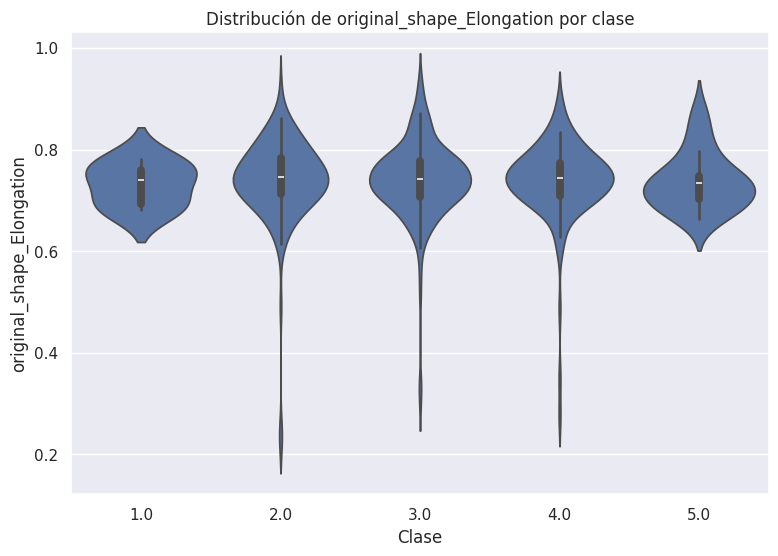

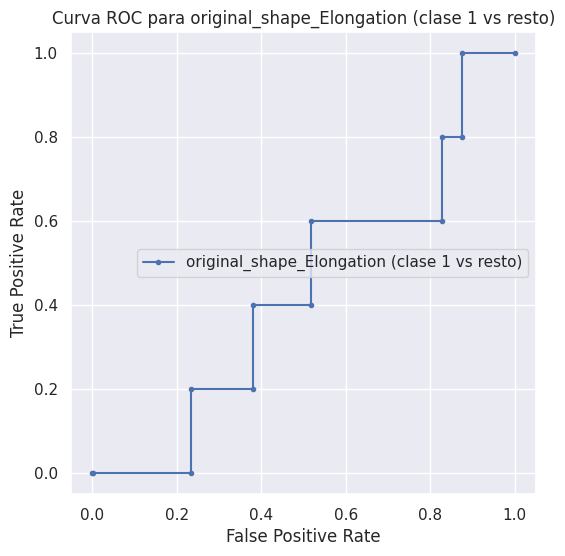

In [141]:
dropdown = 'original_shape_Elongation'  # Cambia por la feature que quieras analizar


sns.set(rc={'figure.figsize': (9, 6)})

# Violin plot
sns.violinplot(x=Y_train, y=X_train[dropdown])
plt.title(f'Distribución de {dropdown} por clase')
plt.xlabel('Clase')
plt.ylabel(dropdown)
plt.show()

# ROC para una clase vs el resto (por ejemplo, clase 1)
clase_objetivo = 1  # Cambia por la clase que te interese
y_binario = (Y_train == clase_objetivo).astype(int)

lr_fpr, lr_tpr, _ = roc_curve(y_binario, X_train[dropdown])
plt.figure(figsize=(6, 6))
plt.plot(lr_fpr, lr_tpr, marker='.', label=f'{dropdown} (clase {clase_objetivo} vs resto)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC para {dropdown} (clase {clase_objetivo} vs resto)')
plt.legend()
plt.show()

Lets count how many features are statistically significant between groups after the multiple comparisons correction

In [142]:
print(sum(i < 0.05 for i in corrected_p_value))

#It seems that after correcting for the multiple comparisons no feature remains statistically significant. 
# Nonetheless, we will try to use the best features to create a multivariable mod

1277


In [23]:
num_features_model = round(X[dropdown].shape[0]/15) #sum(i < 0.05 for i in train_auc_pvals_df['p-value'])
print(num_features_model)
train_df = train_auc_pvals_df.sort_values(by='p-value', ascending=True)
selected_features = train_df.index[0:num_features_model]

X_new = X[selected_features]

48


# CARACTERISTICAS RELEVANTES

In [144]:
print(label_csv)
print(selected_features)
# Guarda las características relevantes en un CSV
pd.Series(selected_features).to_csv(f'/mnt/datalake/openmind/MedP-Midas/data/selected_features/selected_features_{label_csv}.csv', index=False, header=['feature'])

label5
Index(['original_glcm_Imc2', 'log-sigma-0-6-mm-3D_firstorder_10Percentile',
       'squareroot_glcm_Imc2', 'original_glcm_ClusterTendency',
       'exponential_firstorder_RobustMeanAbsoluteDeviation',
       'squareroot_firstorder_Kurtosis',
       'exponential_firstorder_MeanAbsoluteDeviation',
       'original_ngtdm_Contrast', 'original_glcm_SumSquares',
       'logarithm_glcm_Imc2', 'squareroot_firstorder_90Percentile',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_glcm_SumEntropy', 'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_90Percentile', 'original_glrlm_RunEntropy',
       'logarithm_firstorder_Kurtosis', 'wavelet2-LL_glcm_Imc2',
       'exponential_firstorder_InterquartileRange',
       'logarithm_firstorder_90Percentile', 'original_glcm_Correlation',
       'logarithm_firstorder_Skewness',
       'original_firstorder_InterquartileRange', 'squareroot_glcm_Idmn',
       'original_gldm_GrayLevelVariance', 'original_f

Select optimization metric


In [145]:
optimization_metric = "AUC" #["AUC", "MCC", "Kappa","F1", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV", "BalancedAcc"]

if optimization_metric == "AUC":
    score_str = 'roc_auc_ovr' #multiclass
elif optimization_metric == "MCC":
    score_str = make_scorer(matthews_corrcoef)
elif optimization_metric == "Kappa":
    score_str = make_scorer(cohen_kappa_score)
elif optimization_metric == "F1":
    score_str = 'f1'
elif optimization_metric == "Accuracy":
    score_str = 'accuracy'
elif optimization_metric == "Sensitivity":
    score_str = 'recall'
elif optimization_metric == "Specificity":
    score_str = make_scorer(recall_score)
elif optimization_metric == "PPV":
    score_str = 'precision'
elif optimization_metric == "NPV":
    score_str = make_scorer(precision_score)
elif optimization_metric == "BalancedAcc":
    score_str = 'balanced_accuracy'

score_group = {
    'AUC': 'roc_auc_ovr',
    'MCC': make_scorer(matthews_corrcoef),
    'Kappa': make_scorer(cohen_kappa_score),
    'F1': make_scorer(f1_score, average='macro'),
    'Accuracy': 'accuracy',
    'Sensitivity': make_scorer(recall_score, average='macro'),
    'Specificity': make_scorer(recall_score, average='macro'),
    'PPV': make_scorer(precision_score, average='macro'),
    'NPV': make_scorer(precision_score, average='macro'),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

score_refit_str = optimization_metric

# Classifiers Comparison 

In [146]:
SVM_classifier = True
LogisticRegression_classifier = False
RandomForest_classifier = True
NaiveBayes_classifier = True
KNN_classifier = False
GradientBoosting_classifier = False

In [147]:
df_ncv_scores = pd.DataFrame(columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
if SVM_classifier:
    pipe_svc = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             SVC(random_state=random_state_value,  probability=True))

    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_grid_svc = [{'svc__C': param_range, 
                  'svc__kernel': ['linear']},
                  {'svc__C': param_range, 
                  'svc__gamma': param_range, 
                  'svc__kernel': ['rbf']}]

    gs_svc = GridSearchCV(estimator=pipe_svc, 
                      param_grid=param_grid_svc, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_scv = cross_val_score(gs_svc, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['SVM'], 'Nested-CV Mean': [np.mean(scores_scv)], 'Nested-CV Std': [np.std(scores_scv)]}, columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)
    
if LogisticRegression_classifier:
    pipe_lr = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            LogisticRegression(random_state=random_state_value, #penalty='elasticnet', 
                                           solver='saga'))

    param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_range_penalty = ['l1']

    param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                     'logisticregression__C': param_range_lr,
                     }

    gs_lr = GridSearchCV(estimator=pipe_lr, 
                      param_grid=param_grid_lr, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_lr = cross_val_score(gs_lr, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Logistic Regression'], 'Nested-CV Mean': [np.mean(scores_lr)], 'Nested-CV Std': [np.std(scores_lr)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if RandomForest_classifier:
    pipe_rf = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

    param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                    'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    gs_rf = GridSearchCV(estimator=pipe_rf, 
                      param_grid=param_grid_rf, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_rf = cross_val_score(gs_rf, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Random Forest'], 'Nested-CV Mean': [np.mean(scores_rf)], 'Nested-CV Std': [np.std(scores_rf)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if NaiveBayes_classifier:
    pipe_nb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GaussianNB())

    param_grid_nb = {}

    gs_nb = GridSearchCV(estimator=pipe_nb, 
                      param_grid=param_grid_nb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_nb = cross_val_score(gs_nb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Naive Bayes'], 'Nested-CV Mean': [np.mean(scores_nb)], 'Nested-CV Std': [np.std(scores_nb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if KNN_classifier:
    pipe_knn = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

    param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

    param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                    'kneighborsclassifier__weights': ['uniform', 'distance']}

    gs_knn = GridSearchCV(estimator=pipe_knn, 
                      param_grid=param_grid_knn, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_knn = cross_val_score(gs_knn, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['KNN'], 'Nested-CV Mean': [np.mean(scores_knn)], 'Nested-CV Std': [np.std(scores_knn)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if GradientBoosting_classifier:
    pipe_gb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GradientBoostingClassifier(random_state=random_state_value))

    param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

    param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                    'gradientboostingclassifier__learning_rate': param_learnrate_gb}

    gs_gb = GridSearchCV(estimator=pipe_gb, 
                      param_grid=param_grid_gb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_gb = cross_val_score(gs_gb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Gradient Boosting'], 'Nested-CV Mean': [np.mean(scores_gb)], 'Nested-CV Std': [np.std(scores_gb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

df_ncv_scores.sort_values(by=df_ncv_scores.columns[1], ascending=False)


/tmp/ipykernel_2233854/1871017026.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)


,Classifier,Nested-CV Mean,Nested-CV Std
1,Random Forest,0.794846,0.048992
0,SVM,0.793220,0.034797
2,Naive Bayes,0.745716,0.065695


# Select classifier to train/fine-tune model

In [148]:
selected_model = 'RandomForest'  # Cambia por el modelo que quieras usar

number_folds = 5

Train/Fine-tune selected model

In [149]:
if selected_model == 'SVM':
  pipe_svc = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           SVC(random_state=random_state_value, probability=True))

  param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_grid_svc = [{'svc__C': param_range, 
                'svc__kernel': ['linear']},
                {'svc__C': param_range, 
                'svc__gamma': param_range, 
                'svc__kernel': ['rbf']}]

  gs_svc = GridSearchCV(estimator=pipe_svc, 
                    param_grid=param_grid_svc, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_svc.fit(X_train_new, y_train)
  clf_svc = gs.best_estimator_
          
elif selected_model == 'LogisticRegression':
  pipe_lr = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          LogisticRegression(penalty='elasticnet', random_state=random_state_value,
                                            solver='saga'))

  param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_l1_ratio_lr = np.linspace(0,1,11)

  param_range_penalty = ['l1']

  param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                   'logisticregression__C': param_range_lr}

  gs_lr = GridSearchCV(estimator=pipe_lr, 
                    param_grid=param_grid_lr, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_lr.fit(X_train_new, y_train)
  clf_lr = gs.best_estimator_

elif selected_model == 'RandomForest':
  pipe_rf = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

  param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

  param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                  'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

  gs_rf = GridSearchCV(estimator=pipe_rf, 
                    param_grid=param_grid_rf, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_rf.fit(X_train_new, y_train)
  clf_rf = gs.best_estimator_

elif selected_model == 'NaiveBayes':
  pipe_nb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GaussianNB())

  param_grid_nb = {}

  gs_nb = GridSearchCV(estimator=pipe_nb, 
                    param_grid=param_grid_nb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_nb.fit(X_train_new, y_train)
  clf_nb = gs.best_estimator_
  
elif selected_model == 'KNN':
  pipe_knn = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

  param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

  param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                  'kneighborsclassifier__weights': ['uniform', 'distance']}

  gs_knn = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid_knn, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_knn.fit(X_train_new, y_train)
  clf_knn = gs.best_estimator_
  
elif selected_model == 'GradientBoosting':
  pipe_gb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GradientBoostingClassifier(random_state=random_state_value))

  param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
  param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

  param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                  'gradientboostingclassifier__learning_rate': param_learnrate_gb}

  gs_gb = GridSearchCV(estimator=pipe_gb, 
                    param_grid=param_grid_gb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_gb.fit(X_train_new, y_train)
  clf_gb = gs.best_estimator_

print(gs.best_params_)
for key in score_group:
    if len(gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1])>1:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1][0],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1][0]))
    else:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1]))


/mnt/datalake/openmind/MedP-Midas/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/datalake/openmind/MedP-Midas/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/datalake/openmind/MedP-Midas/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

{'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 1024}
CV AUC: 0.816 +/- 0.042
CV MCC: 0.399 +/- 0.029
CV Kappa: 0.390 +/- 0.032
CV F1: 0.383 +/- 0.051
CV Accuracy: 0.623 +/- 0.016
CV Sensitivity: 0.377 +/- 0.035
CV Specificity: 0.377 +/- 0.035
CV PPV: 0.424 +/- 0.087
CV NPV: 0.424 +/- 0.087
CV BalancedAcc: 0.377 +/- 0.035


/tmp/ipykernel_2233854/2146970009.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('CV %s: %.3f +/- %.3f' % (key,


# -----------------